In [1]:
!pip install timm

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter
import timm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Set Seeds for Reproducibility

In [3]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [4]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False, imaging_type_encoder=None):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
            imaging_type_encoder (LabelEncoder, optional): Pre-fitted imaging type encoder.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        # Handle imaging type encoding
        if imaging_type_encoder is None:
            self.imaging_type_encoder = LabelEncoder()
            if fit_label_encoder:  # Use same flag as label encoder for consistency
                self.imaging_types = self.imaging_type_encoder.fit_transform(self.data['imaging type'])
            else:
                raise ValueError("Must provide imaging_type_encoder or set fit_label_encoder=True")
        else:
            self.imaging_type_encoder = imaging_type_encoder
            self.imaging_types = self.imaging_type_encoder.transform(self.data['imaging type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        imaging_type = self.imaging_types[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(imaging_type, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_imaging_type_encoder(self):
        """Return the imaging type encoder for use with other datasets"""
        return self.imaging_type_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder
    le = train_dataset.get_label_encoder()
    
    # Get the fitted imaging type encoder
    imaging_type_encoder = train_dataset.get_imaging_type_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    return train_dataset, val_dataset, test_dataset, le, imaging_type_encoder

# Dataloader

In [7]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [8]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder, imaging_type_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels, _ in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels, imaging_types in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    imaging_types = imaging_types.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs, imaging_types)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels, imaging_types in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                imaging_types = imaging_types.to(self.device)
                
                outputs = self.model(inputs, imaging_types)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [12]:
class ConvNeXtWithImagingType(nn.Module):
    """Wrapper class that adds imaging type embedding to ConvNeXt"""
    def __init__(self, base_model, num_features, num_classes=4, num_imaging_types=2, embedding_dim=16):
        super(ConvNeXtWithImagingType, self).__init__()
        self.base_model = base_model
        
        # Replace the head with identity to get features
        self.base_model.head.fc = nn.Identity()
        
        # Create embedding for imaging type
        self.imaging_type_embedding = nn.Embedding(num_imaging_types, embedding_dim)
        
        # New classifier that takes image features + imaging type embedding
        self.classifier = nn.Linear(num_features + embedding_dim, num_classes)
        
    def forward(self, x, imaging_type):
        # Get image features from base model
        image_features = self.base_model(x)
        
        # Get imaging type embedding
        imaging_embedding = self.imaging_type_embedding(imaging_type)
        
        # Concatenate features
        combined_features = torch.cat([image_features, imaging_embedding], dim=1)
        
        # Final classification
        output = self.classifier(combined_features)
        return output

def create_convnext_model(architecture='convnext_tiny', num_classes=4, num_imaging_types=2, pretrained=True):
    """Create ConvNeXt model with imaging type support for multi-class classification"""
    if architecture == 'convnext_tiny':
        base_model = timm.create_model('convnext_tiny', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'convnext_small':
        base_model = timm.create_model('convnext_small', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'convnext_base':
        base_model = timm.create_model('convnext_base', pretrained=pretrained, num_classes=num_classes)
    else:
        raise ValueError("Architecture must be 'convnext_tiny', 'convnext_small', or 'convnext_base'")
    
    # Get number of features before modifying the head
    num_features = base_model.head.fc.in_features
    
    # Wrap model with imaging type support
    model = ConvNeXtWithImagingType(
        base_model,
        num_features=num_features,
        num_classes=num_classes,
        num_imaging_types=num_imaging_types
    )
    
    return model

# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train ConvNeXt Tiny

Training ConvNeXt Tiny with Imaging Type


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:30<00:00,  1.25it/s, Loss=1.7307, Acc=0.2599]


Train Loss: 1.7307 Acc: 0.2599 Macro-F1: 0.2268


Val : 100%|██████████| 10/10 [00:03<00:00,  2.69it/s, Loss=1.5374, Acc=0.3289]


Val Loss: 1.5374 Acc: 0.3289 Macro-F1: 0.1849
✓ New best model saved with validation macro-F1: 0.1849

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.39it/s, Loss=1.4122, Acc=0.2467]


Train Loss: 1.4122 Acc: 0.2467 Macro-F1: 0.2312


Val : 100%|██████████| 10/10 [00:01<00:00,  8.03it/s, Loss=1.3597, Acc=0.2763]


Val Loss: 1.3597 Acc: 0.2763 Macro-F1: 0.1082

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.39it/s, Loss=1.4209, Acc=0.2558]


Train Loss: 1.4209 Acc: 0.2558 Macro-F1: 0.2231


Val : 100%|██████████| 10/10 [00:01<00:00,  7.85it/s, Loss=1.3391, Acc=0.3158]


Val Loss: 1.3391 Acc: 0.3158 Macro-F1: 0.1792

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.39it/s, Loss=1.3957, Acc=0.2467]


Train Loss: 1.3957 Acc: 0.2467 Macro-F1: 0.2256


Val : 100%|██████████| 10/10 [00:01<00:00,  8.00it/s, Loss=1.4203, Acc=0.3289]


Val Loss: 1.4203 Acc: 0.3289 Macro-F1: 0.1849

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.39it/s, Loss=1.4035, Acc=0.2730]


Train Loss: 1.4035 Acc: 0.2730 Macro-F1: 0.2550


Val : 100%|██████████| 10/10 [00:01<00:00,  7.95it/s, Loss=1.4026, Acc=0.2895]


Val Loss: 1.4026 Acc: 0.2895 Macro-F1: 0.1768

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.39it/s, Loss=1.4006, Acc=0.2681]


Train Loss: 1.4006 Acc: 0.2681 Macro-F1: 0.2395


Val : 100%|██████████| 10/10 [00:01<00:00,  7.94it/s, Loss=1.3803, Acc=0.2500]


Val Loss: 1.3803 Acc: 0.2500 Macro-F1: 0.1595
Early stopping triggered after 6 epochs
Training complete in 2m 57s
Best validation macro-F1: 0.1849


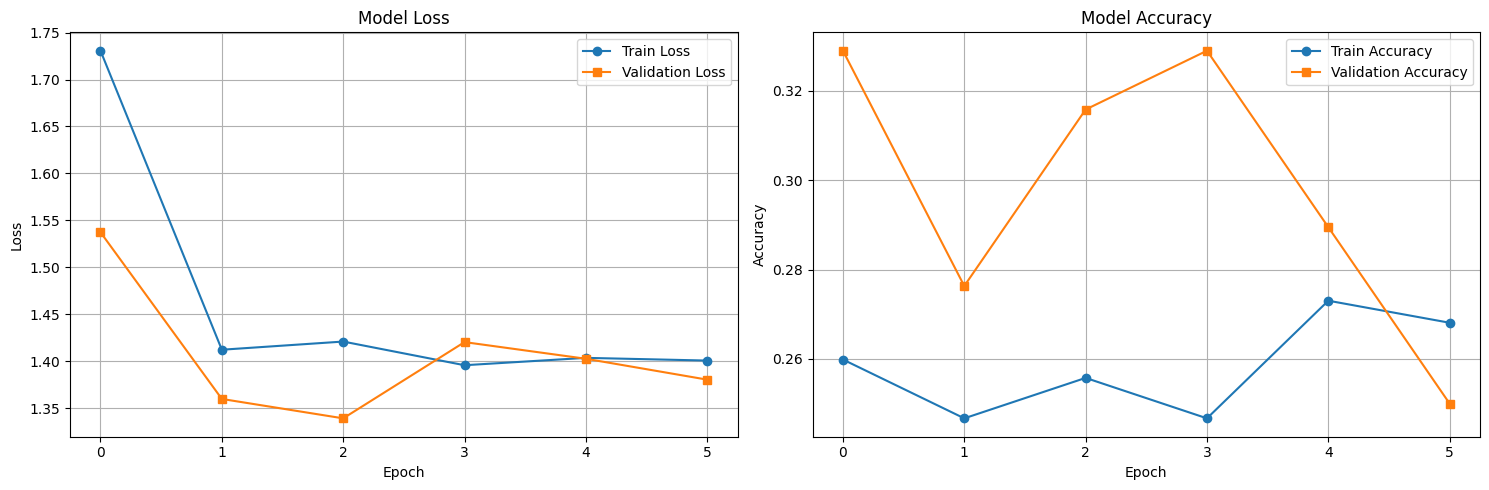

Evaluating on test set...


100%|██████████| 6/6 [00:03<00:00,  1.93it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/us

Test Accuracy: 13.76%
Test Loss: 1.5072

Classification Report:
              precision    recall  f1-score   support

         HGC       0.00      0.00      0.00        74
         LGC       0.17      0.49      0.26        53
         NST       0.00      0.00      0.00        37
         NTL       0.00      0.00      0.00        25

    accuracy                           0.14       189
   macro avg       0.04      0.12      0.06       189
weighted avg       0.05      0.14      0.07       189


Confusion Matrix:
[[ 0 62  0 12]
 [ 0 26  0 27]
 [ 0 37  0  0]
 [ 0 25  0  0]]

ROC-AUC Scores:
Macro-average AUC: 0.6811
Micro-average AUC: 0.4941
HGC AUC: 0.7746
LGC AUC: 0.4396
NST AUC: 0.8992
NTL AUC: 0.6110


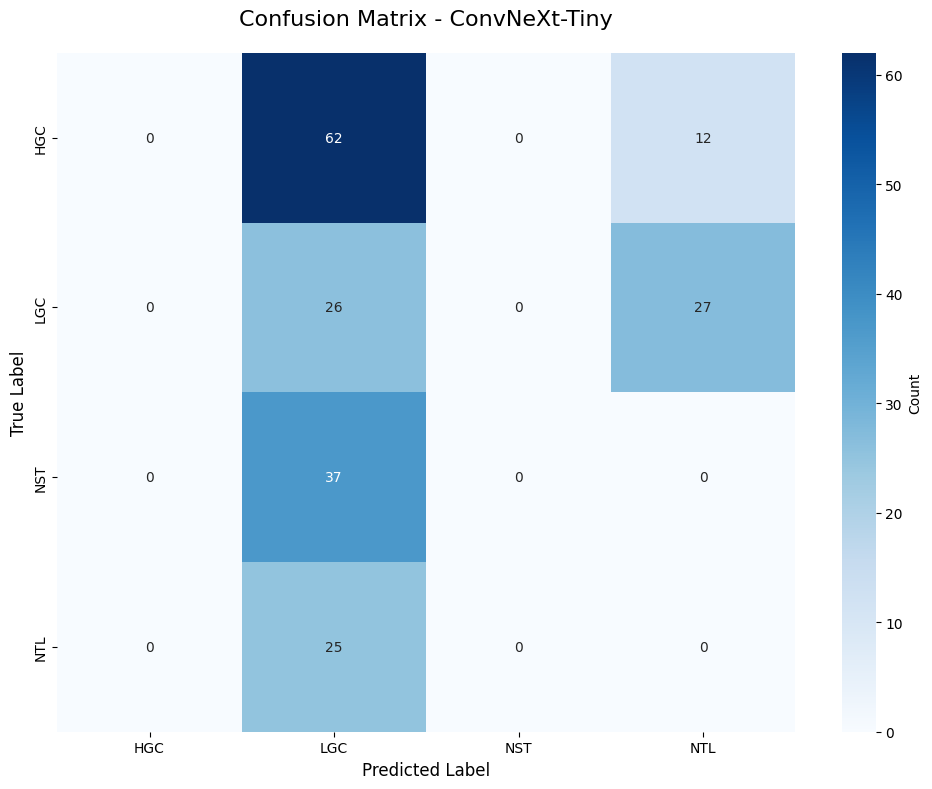

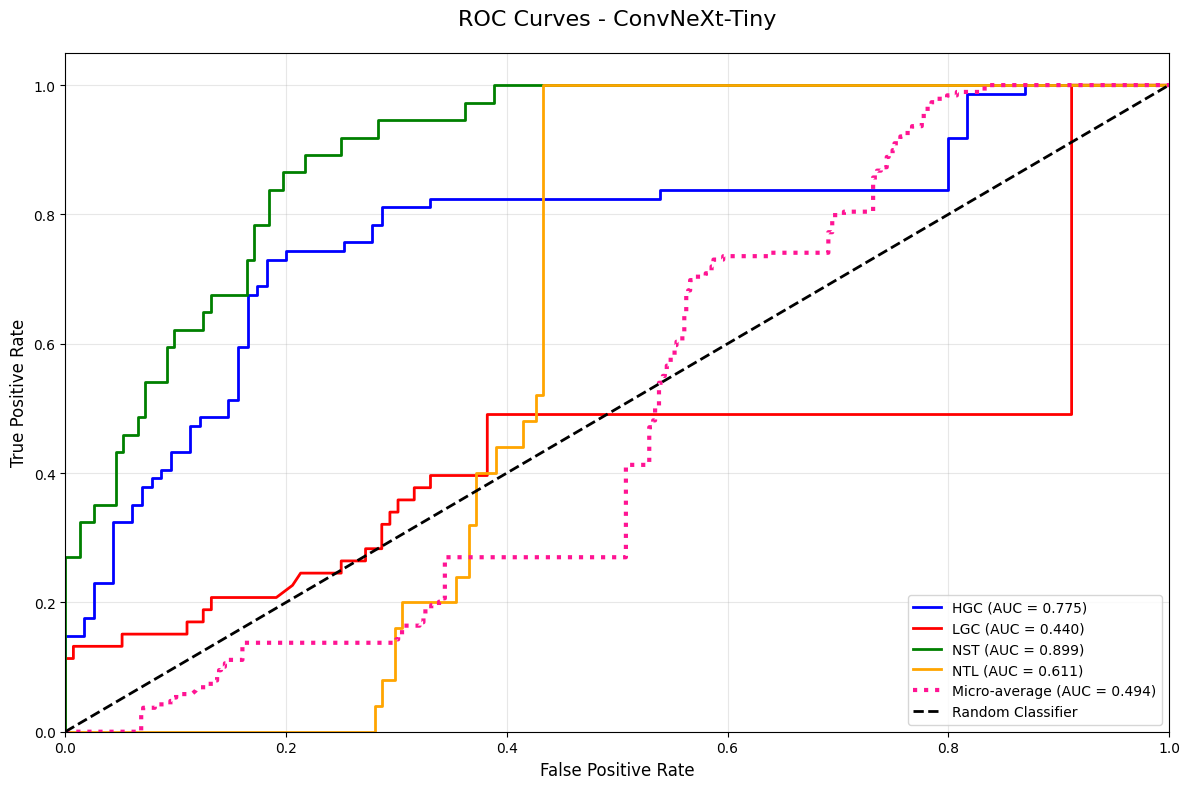


ConvNeXt Tiny training and evaluation complete!


In [16]:
print("=" * 80)
print("Training ConvNeXt Tiny with Imaging Type")
print("=" * 80)

# Create model
convnext_tiny = create_convnext_model(architecture='convnext_tiny', num_classes=4, num_imaging_types=2, pretrained=True)

# Create trainer
trainer_convnext_tiny = ModelTrainer(convnext_tiny, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_convnext_tiny = trainer_convnext_tiny.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="ConvNeXt-Tiny_with_ImagingType")

# Plot training history
trainer_convnext_tiny.plot_training_history(save_path='convnext_tiny_training_history.png')

# Evaluate model
results_convnext_tiny = trainer_convnext_tiny.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_convnext_tiny['confusion_matrix'], class_names, 'ConvNeXt-Tiny',
                      save_path='convnext_tiny_confusion_matrix.png')

# Plot ROC curves
roc_auc_convnext_tiny = plot_roc_curves(results_convnext_tiny['labels'], results_convnext_tiny['probabilities'], class_names, 'ConvNeXt-Tiny',
                                     save_path='convnext_tiny_roc_curves.png')

# Store results
results_convnext_tiny['model_name'] = 'ConvNeXt-Tiny_with_ImagingType'
results_convnext_tiny['roc_auc'] = roc_auc_convnext_tiny
all_results.append(results_convnext_tiny)

print("\nConvNeXt Tiny training and evaluation complete!")

## Train ConvNeXt Base

Training ConvNeXt Base with Imaging Type


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:58<00:00,  1.54s/it, Loss=1.5384, Acc=0.2812]


Train Loss: 1.5384 Acc: 0.2812 Macro-F1: 0.2524


Val : 100%|██████████| 10/10 [00:04<00:00,  2.35it/s, Loss=1.3542, Acc=0.3684]


Val Loss: 1.3542 Acc: 0.3684 Macro-F1: 0.1346
✓ New best model saved with validation macro-F1: 0.1346

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=1.4146, Acc=0.2179]


Train Loss: 1.4146 Acc: 0.2179 Macro-F1: 0.2132


Val : 100%|██████████| 10/10 [00:02<00:00,  3.92it/s, Loss=1.3169, Acc=0.3684]


Val Loss: 1.3169 Acc: 0.3684 Macro-F1: 0.1346

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=1.2303, Acc=0.4622]


Train Loss: 1.2303 Acc: 0.4622 Macro-F1: 0.4154


Val : 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, Loss=1.2056, Acc=0.6118]


Val Loss: 1.2056 Acc: 0.6118 Macro-F1: 0.5159
✓ New best model saved with validation macro-F1: 0.5159

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=1.3117, Acc=0.4342]


Train Loss: 1.3117 Acc: 0.4342 Macro-F1: 0.3730


Val : 100%|██████████| 10/10 [00:02<00:00,  3.93it/s, Loss=1.2786, Acc=0.5855]


Val Loss: 1.2786 Acc: 0.5855 Macro-F1: 0.5070

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=1.2155, Acc=0.5058]


Train Loss: 1.2155 Acc: 0.5058 Macro-F1: 0.4418


Val : 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, Loss=1.0685, Acc=0.6053]


Val Loss: 1.0685 Acc: 0.6053 Macro-F1: 0.4795

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=1.0890, Acc=0.6192]


Train Loss: 1.0890 Acc: 0.6192 Macro-F1: 0.5094


Val : 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, Loss=0.9622, Acc=0.6118]


Val Loss: 0.9622 Acc: 0.6118 Macro-F1: 0.5016

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=1.0751, Acc=0.5995]


Train Loss: 1.0751 Acc: 0.5995 Macro-F1: 0.5225


Val : 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, Loss=0.8640, Acc=0.7039]


Val Loss: 0.8640 Acc: 0.7039 Macro-F1: 0.6041
✓ New best model saved with validation macro-F1: 0.6041

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=0.9090, Acc=0.6998]


Train Loss: 0.9090 Acc: 0.6998 Macro-F1: 0.6104


Val : 100%|██████████| 10/10 [00:02<00:00,  3.87it/s, Loss=0.8068, Acc=0.7039]


Val Loss: 0.8068 Acc: 0.7039 Macro-F1: 0.6009

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=0.8594, Acc=0.7196]


Train Loss: 0.8594 Acc: 0.7196 Macro-F1: 0.6352


Val : 100%|██████████| 10/10 [00:02<00:00,  3.77it/s, Loss=0.7486, Acc=0.7204]


Val Loss: 0.7486 Acc: 0.7204 Macro-F1: 0.6218
✓ New best model saved with validation macro-F1: 0.6218

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=0.8101, Acc=0.7294]


Train Loss: 0.8101 Acc: 0.7294 Macro-F1: 0.6408


Val : 100%|██████████| 10/10 [00:02<00:00,  3.84it/s, Loss=0.6805, Acc=0.7467]


Val Loss: 0.6805 Acc: 0.7467 Macro-F1: 0.6720
✓ New best model saved with validation macro-F1: 0.6720

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=0.7712, Acc=0.7270]


Train Loss: 0.7712 Acc: 0.7270 Macro-F1: 0.6444


Val : 100%|██████████| 10/10 [00:02<00:00,  3.84it/s, Loss=0.6548, Acc=0.7401]


Val Loss: 0.6548 Acc: 0.7401 Macro-F1: 0.6680

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=0.7090, Acc=0.7549]


Train Loss: 0.7090 Acc: 0.7549 Macro-F1: 0.6716


Val : 100%|██████████| 10/10 [00:02<00:00,  3.82it/s, Loss=0.6138, Acc=0.7730]


Val Loss: 0.6138 Acc: 0.7730 Macro-F1: 0.6951
✓ New best model saved with validation macro-F1: 0.6951

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=0.6702, Acc=0.7812]


Train Loss: 0.6702 Acc: 0.7812 Macro-F1: 0.7000


Val : 100%|██████████| 10/10 [00:02<00:00,  3.85it/s, Loss=0.5851, Acc=0.7697]


Val Loss: 0.5851 Acc: 0.7697 Macro-F1: 0.6939

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=0.6366, Acc=0.7804]


Train Loss: 0.6366 Acc: 0.7804 Macro-F1: 0.7150


Val : 100%|██████████| 10/10 [00:02<00:00,  3.89it/s, Loss=0.5443, Acc=0.8224]


Val Loss: 0.5443 Acc: 0.8224 Macro-F1: 0.7536
✓ New best model saved with validation macro-F1: 0.7536

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.50s/it, Loss=0.5692, Acc=0.8191]


Train Loss: 0.5692 Acc: 0.8191 Macro-F1: 0.7551


Val : 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, Loss=0.4862, Acc=0.8520]


Val Loss: 0.4862 Acc: 0.8520 Macro-F1: 0.7932
✓ New best model saved with validation macro-F1: 0.7932

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=0.5015, Acc=0.8577]


Train Loss: 0.5015 Acc: 0.8577 Macro-F1: 0.8160


Val : 100%|██████████| 10/10 [00:02<00:00,  3.89it/s, Loss=0.4477, Acc=0.8454]


Val Loss: 0.4477 Acc: 0.8454 Macro-F1: 0.7899

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=0.4553, Acc=0.8610]


Train Loss: 0.4553 Acc: 0.8610 Macro-F1: 0.8215


Val : 100%|██████████| 10/10 [00:02<00:00,  3.88it/s, Loss=0.4279, Acc=0.8520]


Val Loss: 0.4279 Acc: 0.8520 Macro-F1: 0.7977
✓ New best model saved with validation macro-F1: 0.7977

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=0.4315, Acc=0.8799]


Train Loss: 0.4315 Acc: 0.8799 Macro-F1: 0.8496


Val : 100%|██████████| 10/10 [00:02<00:00,  3.87it/s, Loss=0.4016, Acc=0.8717]


Val Loss: 0.4016 Acc: 0.8717 Macro-F1: 0.8180
✓ New best model saved with validation macro-F1: 0.8180

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=0.4071, Acc=0.8734]


Train Loss: 0.4071 Acc: 0.8734 Macro-F1: 0.8427


Val : 100%|██████████| 10/10 [00:02<00:00,  3.88it/s, Loss=0.3846, Acc=0.8849]


Val Loss: 0.3846 Acc: 0.8849 Macro-F1: 0.8363
✓ New best model saved with validation macro-F1: 0.8363

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=0.3894, Acc=0.8840]


Train Loss: 0.3894 Acc: 0.8840 Macro-F1: 0.8563


Val : 100%|██████████| 10/10 [00:02<00:00,  3.87it/s, Loss=0.3660, Acc=0.8914]


Val Loss: 0.3660 Acc: 0.8914 Macro-F1: 0.8462
✓ New best model saved with validation macro-F1: 0.8462

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=0.3771, Acc=0.8849]


Train Loss: 0.3771 Acc: 0.8849 Macro-F1: 0.8567


Val : 100%|██████████| 10/10 [00:02<00:00,  3.88it/s, Loss=0.3460, Acc=0.8914]


Val Loss: 0.3460 Acc: 0.8914 Macro-F1: 0.8447

Epoch 22/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=0.3523, Acc=0.8939]


Train Loss: 0.3523 Acc: 0.8939 Macro-F1: 0.8747


Val : 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, Loss=0.3475, Acc=0.8980]


Val Loss: 0.3475 Acc: 0.8980 Macro-F1: 0.8560
✓ New best model saved with validation macro-F1: 0.8560

Epoch 23/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=0.3466, Acc=0.8914]


Train Loss: 0.3466 Acc: 0.8914 Macro-F1: 0.8701


Val : 100%|██████████| 10/10 [00:02<00:00,  3.85it/s, Loss=0.3466, Acc=0.9013]


Val Loss: 0.3466 Acc: 0.9013 Macro-F1: 0.8588
✓ New best model saved with validation macro-F1: 0.8588

Epoch 24/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=0.3429, Acc=0.8956]


Train Loss: 0.3429 Acc: 0.8956 Macro-F1: 0.8757


Val : 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, Loss=0.3455, Acc=0.8980]


Val Loss: 0.3455 Acc: 0.8980 Macro-F1: 0.8560

Epoch 25/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.49s/it, Loss=0.3417, Acc=0.8972]


Train Loss: 0.3417 Acc: 0.8972 Macro-F1: 0.8769


Val : 100%|██████████| 10/10 [00:02<00:00,  3.88it/s, Loss=0.3460, Acc=0.8980]


Val Loss: 0.3460 Acc: 0.8980 Macro-F1: 0.8537

Training complete in 24m 56s
Best validation macro-F1: 0.8588


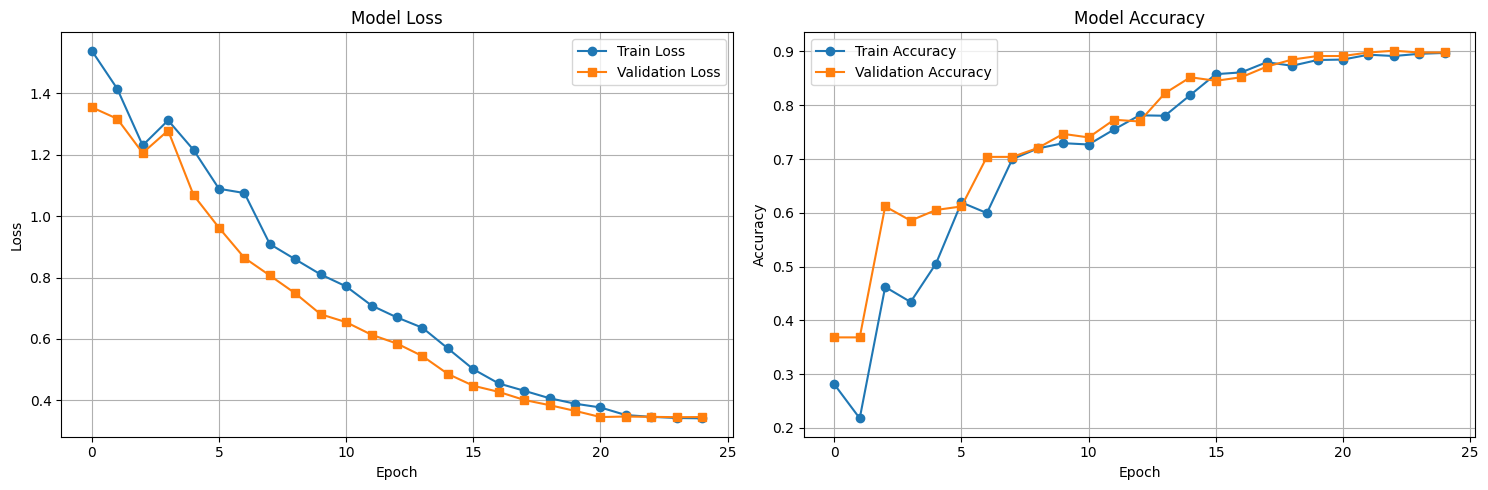

Evaluating on test set...


100%|██████████| 6/6 [00:03<00:00,  1.76it/s]


Test Accuracy: 41.80%
Test Loss: 1.9080

Classification Report:
              precision    recall  f1-score   support

         HGC       0.47      0.64      0.54        74
         LGC       0.36      0.15      0.21        53
         NST       0.39      0.30      0.34        37
         NTL       0.33      0.52      0.41        25

    accuracy                           0.42       189
   macro avg       0.39      0.40      0.37       189
weighted avg       0.41      0.42      0.39       189


Confusion Matrix:
[[47 11 15  1]
 [38  8  0  7]
 [ 5  3 11 18]
 [10  0  2 13]]

ROC-AUC Scores:
Macro-average AUC: 0.7414
Micro-average AUC: 0.7059
HGC AUC: 0.6254
LGC AUC: 0.6579
NST AUC: 0.8457
NTL AUC: 0.8368


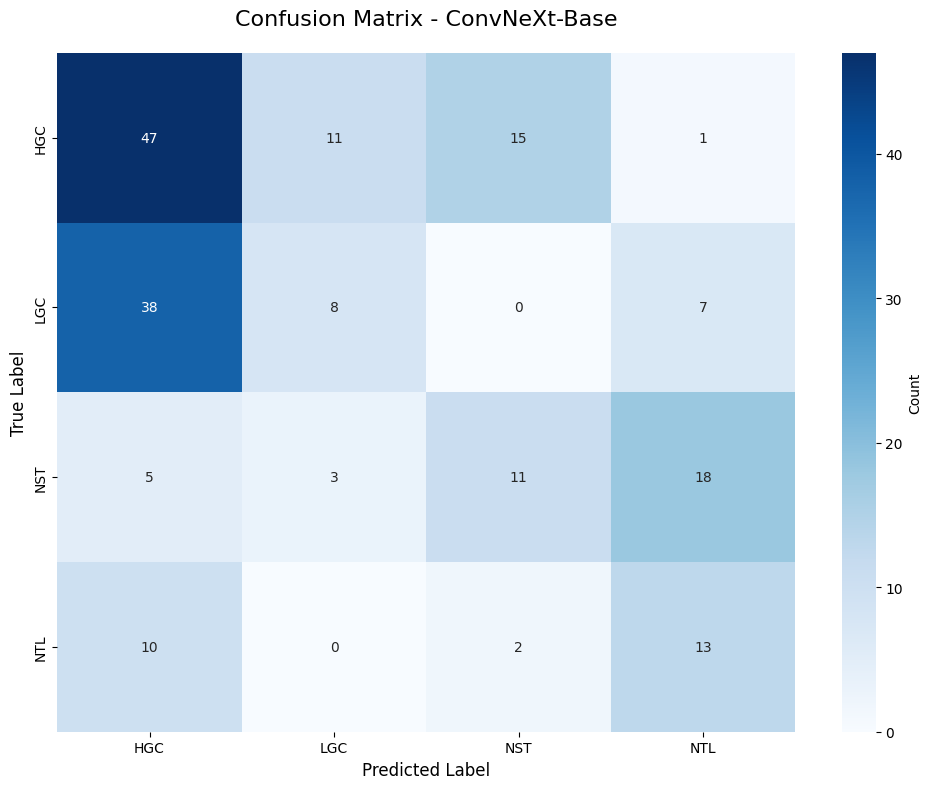

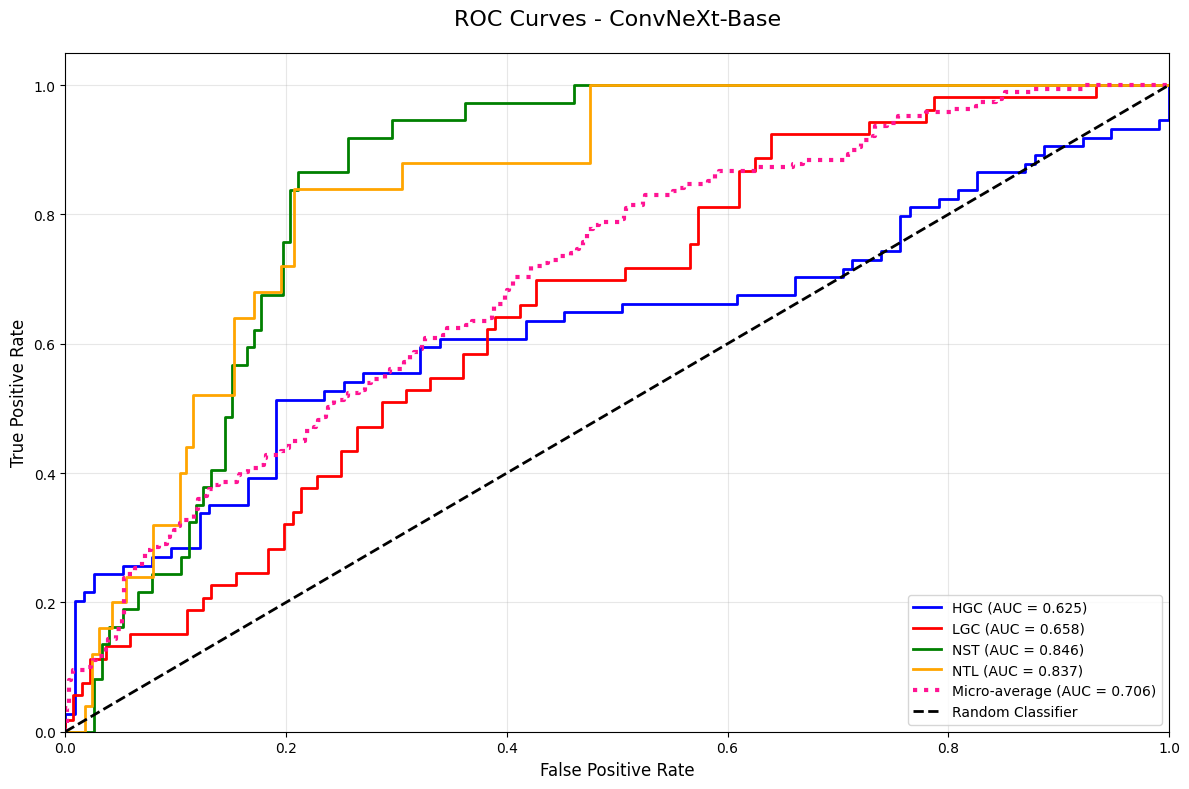


ConvNeXt Base training and evaluation complete!


In [17]:
print("=" * 80)
print("Training ConvNeXt Base with Imaging Type")
print("=" * 80)

# Create model
convnext_base = create_convnext_model(architecture='convnext_base', num_classes=4, num_imaging_types=2, pretrained=True)

# Create trainer
trainer_convnext_base = ModelTrainer(convnext_base, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_convnext_base = trainer_convnext_base.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="ConvNeXt-Base_with_ImagingType")

# Plot training history
trainer_convnext_base.plot_training_history(save_path='convnext_base_training_history.png')

# Evaluate model
results_convnext_base = trainer_convnext_base.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_convnext_base['confusion_matrix'], class_names, 'ConvNeXt-Base',
                      save_path='convnext_base_confusion_matrix.png')

# Plot ROC curves
roc_auc_convnext_base = plot_roc_curves(results_convnext_base['labels'], results_convnext_base['probabilities'], class_names, 'ConvNeXt-Base',
                                     save_path='convnext_base_roc_curves.png')

# Store results
results_convnext_base['model_name'] = 'ConvNeXt-Base_with_ImagingType'
results_convnext_base['roc_auc'] = roc_auc_convnext_base
all_results.append(results_convnext_base)

print("\nConvNeXt Base training and evaluation complete!")

## Train ConvNeXt Small

Training ConvNeXt Small with Imaging Type


model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:41<00:00,  1.10s/it, Loss=1.7746, Acc=0.2171]


Train Loss: 1.7746 Acc: 0.2171 Macro-F1: 0.2036


Val : 100%|██████████| 10/10 [00:01<00:00,  5.35it/s, Loss=1.3525, Acc=0.2829]


Val Loss: 1.3525 Acc: 0.2829 Macro-F1: 0.1103
✓ New best model saved with validation macro-F1: 0.1103

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:41<00:00,  1.10s/it, Loss=1.4443, Acc=0.2590]


Train Loss: 1.4443 Acc: 0.2590 Macro-F1: 0.2351


Val : 100%|██████████| 10/10 [00:01<00:00,  5.22it/s, Loss=1.4566, Acc=0.2895]


Val Loss: 1.4566 Acc: 0.2895 Macro-F1: 0.1768
✓ New best model saved with validation macro-F1: 0.1768

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:41<00:00,  1.10s/it, Loss=1.4153, Acc=0.2360]


Train Loss: 1.4153 Acc: 0.2360 Macro-F1: 0.2236


Val : 100%|██████████| 10/10 [00:01<00:00,  5.32it/s, Loss=1.3638, Acc=0.2500]


Val Loss: 1.3638 Acc: 0.2500 Macro-F1: 0.1595

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:41<00:00,  1.10s/it, Loss=1.4041, Acc=0.2368]


Train Loss: 1.4041 Acc: 0.2368 Macro-F1: 0.2293


Val : 100%|██████████| 10/10 [00:01<00:00,  5.28it/s, Loss=1.3552, Acc=0.2895]


Val Loss: 1.3552 Acc: 0.2895 Macro-F1: 0.1768

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:41<00:00,  1.10s/it, Loss=1.4114, Acc=0.2467]


Train Loss: 1.4114 Acc: 0.2467 Macro-F1: 0.2281


Val : 100%|██████████| 10/10 [00:01<00:00,  5.21it/s, Loss=1.3590, Acc=0.2500]


Val Loss: 1.3590 Acc: 0.2500 Macro-F1: 0.1595

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:41<00:00,  1.10s/it, Loss=1.3996, Acc=0.2278]


Train Loss: 1.3996 Acc: 0.2278 Macro-F1: 0.2194


Val : 100%|██████████| 10/10 [00:01<00:00,  5.29it/s, Loss=1.3602, Acc=0.2895]


Val Loss: 1.3602 Acc: 0.2895 Macro-F1: 0.1768

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:41<00:00,  1.10s/it, Loss=1.3883, Acc=0.2558]


Train Loss: 1.3883 Acc: 0.2558 Macro-F1: 0.2414


Val : 100%|██████████| 10/10 [00:01<00:00,  5.27it/s, Loss=1.4243, Acc=0.2895]


Val Loss: 1.4243 Acc: 0.2895 Macro-F1: 0.1768
Early stopping triggered after 7 epochs
Training complete in 5m 7s
Best validation macro-F1: 0.1768


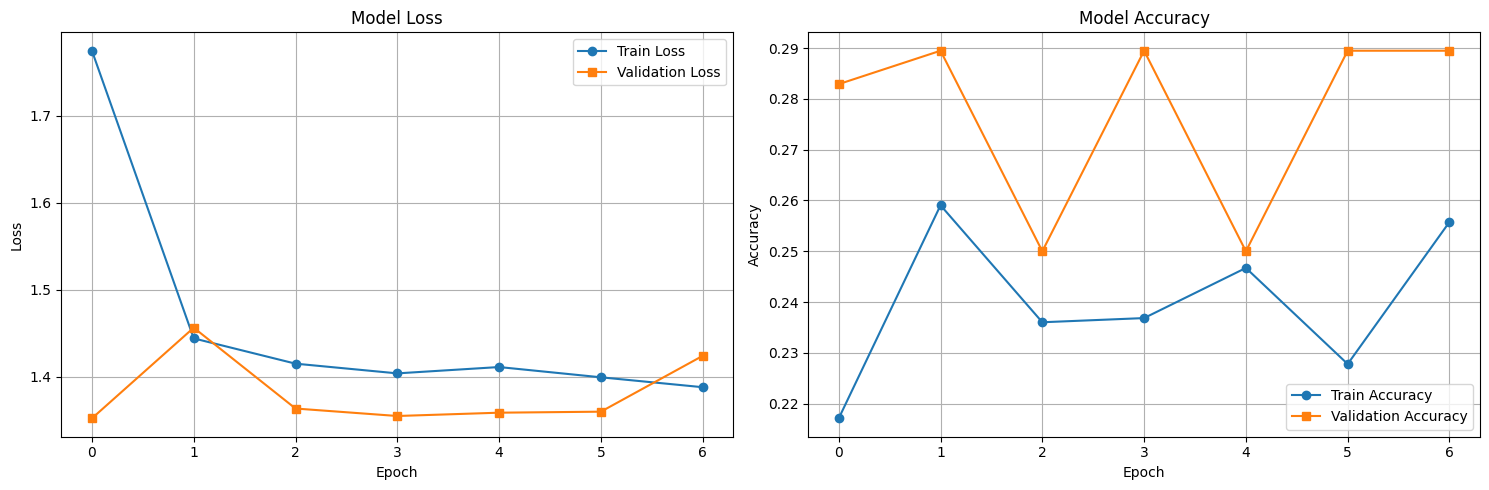

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  4.39it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/us

Test Accuracy: 32.80%
Test Loss: 1.3879

Classification Report:
              precision    recall  f1-score   support

         HGC       0.41      0.84      0.55        74
         LGC       0.00      0.00      0.00        53
         NST       0.00      0.00      0.00        37
         NTL       0.00      0.00      0.00        25

    accuracy                           0.33       189
   macro avg       0.10      0.21      0.14       189
weighted avg       0.16      0.33      0.22       189


Confusion Matrix:
[[62  0  0 12]
 [26  0  0 27]
 [37  0  0  0]
 [25  0  0  0]]

ROC-AUC Scores:
Macro-average AUC: 0.6942
Micro-average AUC: 0.5914
HGC AUC: 0.7887
LGC AUC: 0.4308
NST AUC: 0.8916
NTL AUC: 0.6655


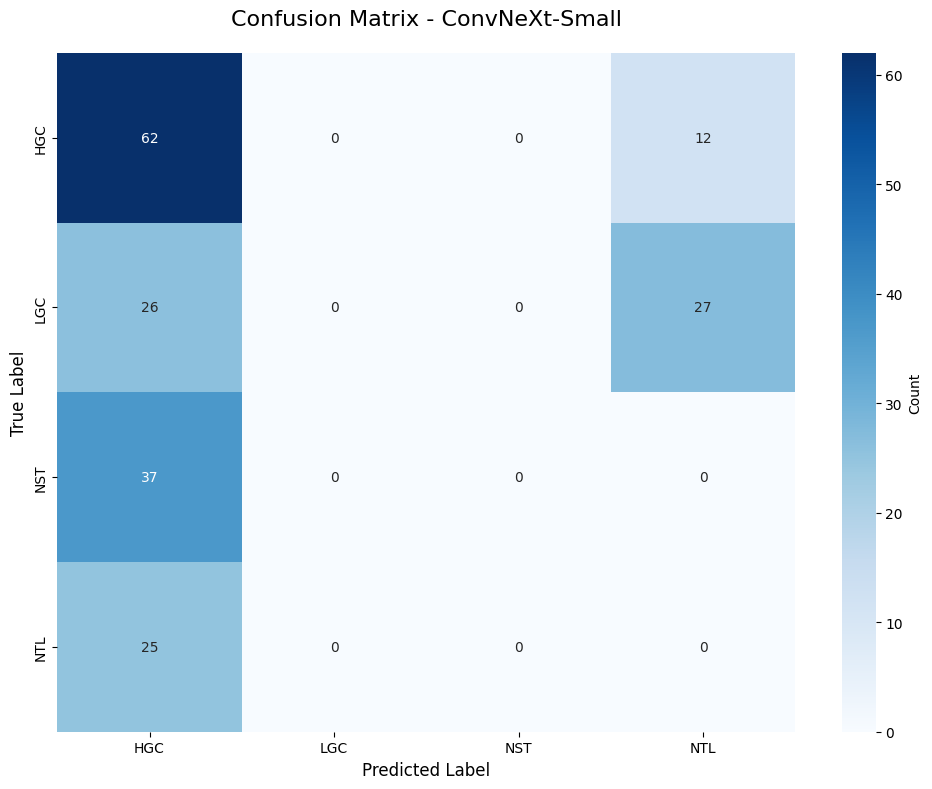

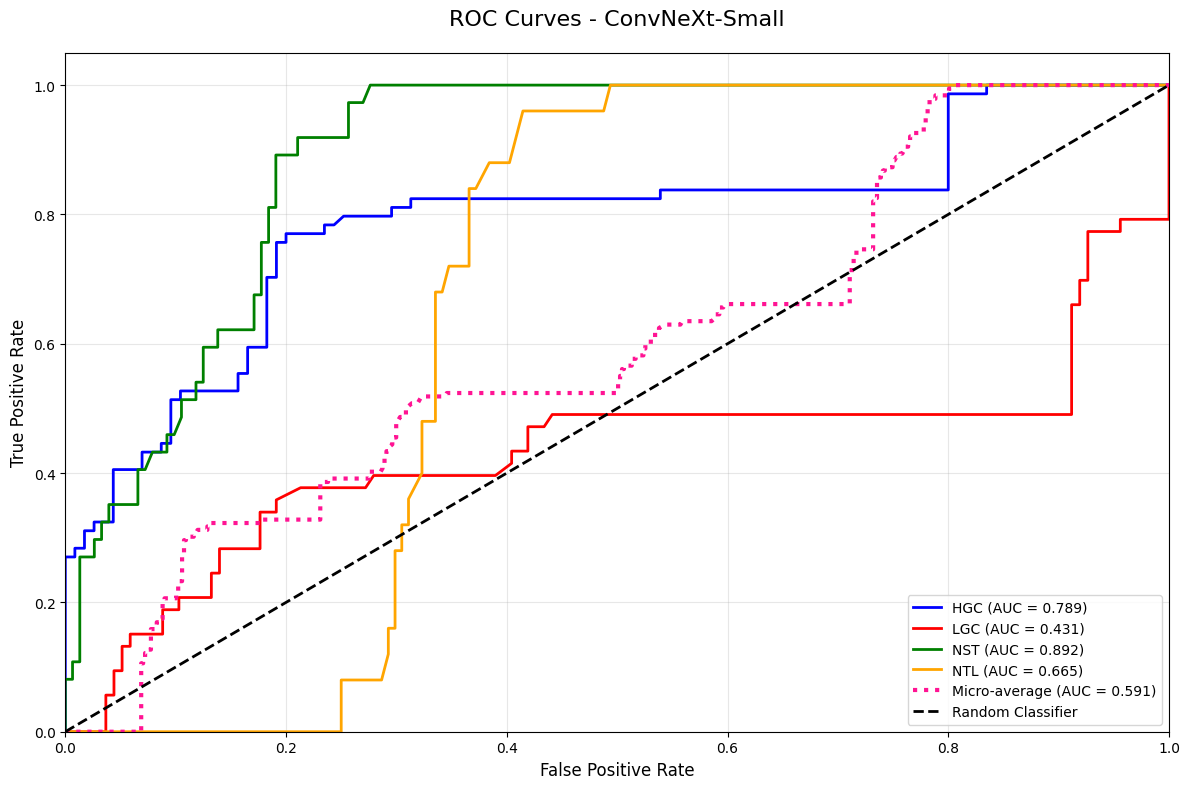


ConvNeXt Small training and evaluation complete!


In [18]:
print("=" * 80)
print("Training ConvNeXt Small with Imaging Type")
print("=" * 80)

# Create model
convnext_small = create_convnext_model(architecture='convnext_small', num_classes=4, num_imaging_types=2, pretrained=True)

# Create trainer
trainer_convnext_small = ModelTrainer(convnext_small, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_convnext_small = trainer_convnext_small.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="ConvNeXt-Small_with_ImagingType")

# Plot training history
trainer_convnext_small.plot_training_history(save_path='convnext_small_training_history.png')

# Evaluate model
results_convnext_small = trainer_convnext_small.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_convnext_small['confusion_matrix'], class_names, 'ConvNeXt-Small',
                      save_path='convnext_small_confusion_matrix.png')

# Plot ROC curves
roc_auc_convnext_small = plot_roc_curves(results_convnext_small['labels'], results_convnext_small['probabilities'], class_names, 'ConvNeXt-Small',
                                     save_path='convnext_small_roc_curves.png')

# Store results
results_convnext_small['model_name'] = 'ConvNeXt-Small_with_ImagingType'
results_convnext_small['roc_auc'] = roc_auc_convnext_small
all_results.append(results_convnext_small)

print("\nConvNeXt Small training and evaluation complete!")

# Save All Metrics to CSV

In [19]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'ConvNeXt_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: ConvNeXt_metrics.csv

Metrics Summary:
                             Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall   NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0   ConvNeXt-Tiny_with_ImagingType         13.756614      1.507189             0.043333          0.122642      0.064039                0.048607             0.137566         0.071833       0.000000    0.000000  0.000000         74.0       0.173333    0.490566  0.256158         53.0       0.000000    0.000000  0.000000         37.0       0.000000        0.00  0.00000         25.0   0.681089   0.494074  0.774618  0.439581 